In [1]:
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
Tamb = 25.3 + 273.15 # K
Pamb = 98.5 # kPa
c0 = 20.047 * Tamb**0.5
rho = 1.290 * Pamb / 101.325 * 273.15 / Tamb
z0 = rho*c0


In [3]:
def postproc_4mic(files, d, s1=45e-3, s2=45e-3, l1=30e-3, l2=50e-3+30e-3, Tamb=25, Pamb=98.5):
    
    meas_1234 = io.loadmat(files[0])
    meas_2134 = io.loadmat(files[1])    
    meas_3214 = io.loadmat(files[2]) 
    meas_4231 = io.loadmat(files[3])

    freq = meas_1234['FFT1_H1_2_1_X_Val'].flatten()

    H12d = meas_1234['FFT1_H1_2_1_Y_ReIm'].flatten()
    H13d = meas_1234['FFT1_H1_3_1_Y_ReIm'].flatten()
    H14d = meas_1234['FFT1_H1_4_1_Y_ReIm'].flatten()

    H12i = meas_2134['FFT1_H1_2_1_Y_ReIm'].flatten()
    H13i = meas_3214['FFT1_H1_3_1_Y_ReIm'].flatten()
    H14i = meas_4231['FFT1_H1_4_1_Y_ReIm'].flatten()
    
    Hc12 = (H12d * H12i)**0.5
    Hc13 = (H13d * H13i)**0.5 
    Hc14 = (H14d * H14i)**0.5
    
    Hf11 = 1
    Hf12 = H12d/Hc12
    Hf13 = H13d/Hc13 
    Hf14 = H14d/Hc14
    
    TambK = Tamb + 273.15 # K
    c0 = 20.047 * TambK**0.5
    rho = 1.290 * Pamb / 101.325 * 273.15 / TambK
    z0 = rho*c0

    k = 2*np.pi*freq / c0

    a = 1j*((Hf11*np.exp(-1j*k*l1) - Hf12*np.exp(-1j*k*(l1+s1))) / (2*np.sin(k*s1))) 
    b = 1j*((Hf12*np.exp(1j*k*(l1+s1)) - Hf11*np.exp(1j*k*(l1))) / (2*np.sin(k*s1))) 
    c = 1j*((Hf13*np.exp(1j*k*(l2+s2)) - Hf14*np.exp(1j*k*(l2))) / (2*np.sin(k*s2))) 
    d = 1j*((Hf14*np.exp(-1j*k*l2) - Hf13*np.exp(-1j*k*(l2+s2))) / (2*np.sin(k*s2)))

    p0 = a + b
    pd = c*np.exp(-1j*k*d) + d*np.exp(1j*k*d)
    u0 = (a - b) / (rho*c0) 
    ud = (c*np.exp(-1j*k*d) - d*np.exp(1j*k*d)) / (rho*c0)

    Tm11 = ((pd*ud + p0*u0) / (p0*ud + pd*u0))#.reshape(-1,1)
    Tm12 = ((p0**2 - pd**2) / (p0*ud + pd*u0))#.reshape(-1,1)
    Tm21 = ((u0**2 - ud**2) / (p0*ud + pd*u0))#.reshape(-1,1)
    Tm22 =((pd*ud + p0*u0) / (p0*ud + pd*u0))#.reshape(-1,1)

    #T_matrix = np.matrix([[T11 , T12], [T21 ,T22]])
    T_matrix = np.empty((2,2), dtype=object)
    T_matrix[0, 0] = Tm11
    T_matrix[0, 1] = Tm12
    T_matrix[1, 0] = Tm21
    T_matrix[1, 1] = Tm22

    R_coef = (T_matrix[0, 0] - rho*c0*T_matrix[1, 0]) / (T_matrix[0, 0] + rho*c0*T_matrix[1, 0]) 
    alpha_coef = 1 - np.abs(R_coef)**2
    kc = (1/d) * np.arccos(T_matrix[0, 0])
    Zc = np.sqrt(T_matrix[0, 1] / T_matrix[1, 0])
    
    return freq, R_coef, alpha_coef, kc, Zc


In [4]:
files = ['YM2_coarse_d1_s1_anec_0,5V_1234.mat', 'YM2_coarse_d1_s1_anec_0,5V_2134.mat', 'YM2_coarse_d1_s1_anec_0,5V_3214.mat', 'YM2_coarse_d1_s1_anec_0,5V_4231.mat']
files2 = ['YM2_coarse_d1_s1_anec_1V_1234.mat', 'YM2_coarse_d1_s1_anec_1V_2134.mat', 'YM2_coarse_d1_s1_anec_1V_3214.mat', 'YM2_coarse_d1_s1_anec_1V_4231.mat']
files3 = ['YM2_coarse_d1_s1_anec_1V_500mm_1234.mat', 'YM2_coarse_d1_s1_anec_1V_500mm_2134.mat', 'YM2_coarse_d1_s1_anec_1V_500mm_3214.mat', 'YM2_coarse_d1_s1_anec_1V_500mm_4231.mat']

l1 = 30e-3
s1 = 45e-3
l2 = 50e-3 + 30e-3
s2 = 45e-3
d = 43e-3

freq, R_anec_low, alpha_anec_low, kc_anec_low, Zc_anec_low = postproc_4mic(files, d, s1, s2, l1, l2)
freq, R_anec_1V, alpha_anec_1V, kc_anec_1V, Zc_anec_1V = postproc_4mic(files2, d)
freq, R_anec_1V_500, alpha_anec_1V_500, kc_anec_1V_500, Zc_anec_1V_500 = postproc_4mic(files3, d, 500e-3, 500e-3, l1, l2)





C:\Users\joaqu\AppData\Local\Temp\ipykernel_901764\1060146679.py:34: RuntimeWarning: divide by zero encountered in true_divide
  a = 1j*((Hf11*np.exp(-1j*k*l1) - Hf12*np.exp(-1j*k*(l1+s1))) / (2*np.sin(k*s1)))
C:\Users\joaqu\AppData\Local\Temp\ipykernel_901764\1060146679.py:34: RuntimeWarning: invalid value encountered in true_divide
  a = 1j*((Hf11*np.exp(-1j*k*l1) - Hf12*np.exp(-1j*k*(l1+s1))) / (2*np.sin(k*s1)))
C:\Users\joaqu\AppData\Local\Temp\ipykernel_901764\1060146679.py:34: RuntimeWarning: invalid value encountered in multiply
  a = 1j*((Hf11*np.exp(-1j*k*l1) - Hf12*np.exp(-1j*k*(l1+s1))) / (2*np.sin(k*s1)))
C:\Users\joaqu\AppData\Local\Temp\ipykernel_901764\1060146679.py:35: RuntimeWarning: divide by zero encountered in true_divide
  b = 1j*((Hf12*np.exp(1j*k*(l1+s1)) - Hf11*np.exp(1j*k*(l1))) / (2*np.sin(k*s1)))
C:\Users\joaqu\AppData\Local\Temp\ipykernel_901764\1060146679.py:35: RuntimeWarning: invalid value encountered in true_divide
  b = 1j*((Hf12*np.exp(1j*k*(l1+s1)) - 

c:\Python39\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
c:\Python39\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
c:\Python39\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.
No handles with labels found to put in legend.


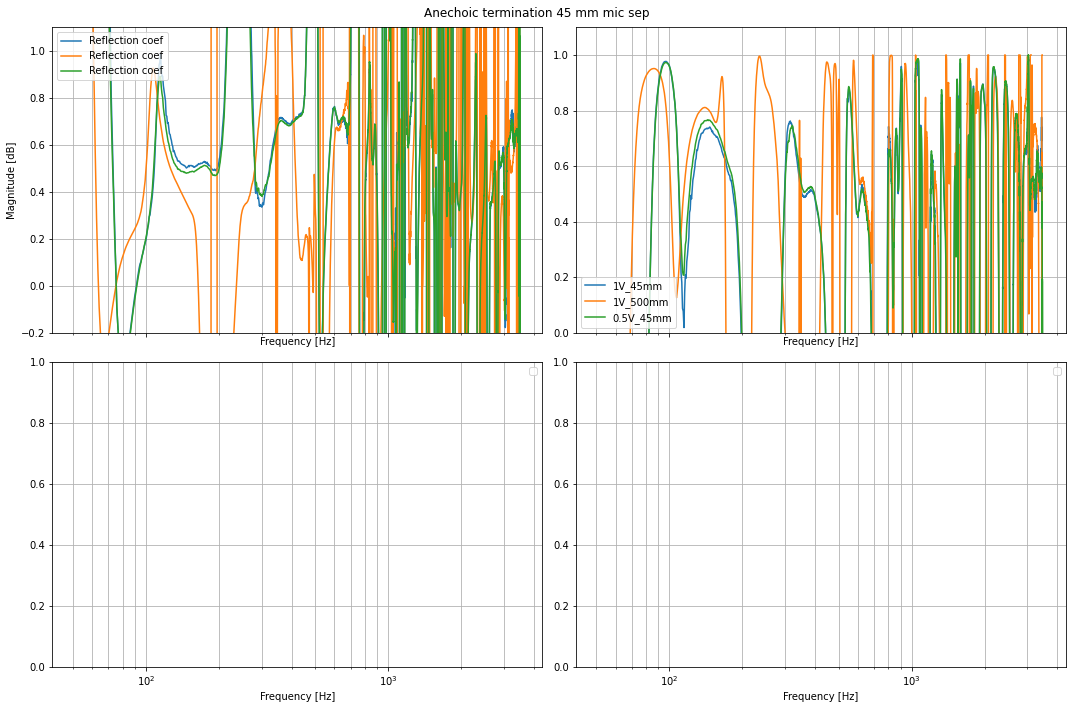

In [5]:
idx = (freq > 50) & (freq< 3500)

fig, ax = plt.subplots(2,2, figsize=(15, 10) ,sharex=True)
ax = ax.flatten()
# ax[0].semilogx(freq[idx], R_coef_anec[idx], label='Reflection coef')
ax[0].semilogx(freq[idx], R_anec_1V[idx], label='Reflection coef')
ax[0].semilogx(freq[idx], R_anec_1V_500[idx], label='Reflection coef')
ax[0].semilogx(freq[idx], R_anec_low[idx], label='Reflection coef')

# ax[1].semilogx(freq[idx], alpha_coef_anec[idx], label='Absorption coef')
ax[1].semilogx(freq[idx], alpha_anec_1V[idx], label='1V_45mm')
ax[1].semilogx(freq[idx], alpha_anec_1V_500[idx], label='1V_500mm')
ax[1].semilogx(freq[idx], alpha_anec_low[idx], label='0.5V_45mm')

# ax[2].semilogx(freq[idx], kc_anec[idx], label='Wavenumber in material kc')
# ax[3].semilogx(freq[idx], Zc_anec[idx], label='Characteristic impedance in material Zc')

ax[0].legend()
ax[0].set_ylabel('Magnitude [dB]')

ax[0].set_ylim([-0.2, 1.1])
ax[1].set_ylim([0, 1.1])

ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

ax[0].grid(which='both')
ax[1].grid(which='both')
ax[2].grid(which='both')
ax[3].grid(which='both')

ax[0].set_xlabel('Frequency [Hz]')
ax[1].set_xlabel('Frequency [Hz]')
ax[2].set_xlabel('Frequency [Hz]')
ax[3].set_xlabel('Frequency [Hz]')

plt.suptitle('Anechoic termination 45 mm mic sep')
plt.tight_layout()

plt.show()

### Measurement with short mic separation (45 mm), anechoic termination, 0.5V source

In [17]:
YM2coarse_anech45_1234 = io.loadmat('YM2_coarse_d1_s1_anec_0,5V_1234.mat')
YM2coarse_anech45_2134 = io.loadmat('YM2_coarse_d1_s1_anec_0,5V_2134.mat')    
YM2coarse_anech45_3214 = io.loadmat('YM2_coarse_d1_s1_anec_0,5V_3214.mat') 
YM2coarse_anech45_4231 = io.loadmat('YM2_coarse_d1_s1_anec_0,5V_4231.mat')

freq = YM2coarse_anech45_1234['FFT1_H1_2_1_X_Val'].flatten()

H12d = YM2coarse_anech45_1234['FFT1_H1_2_1_Y_ReIm'].flatten()
H13d = YM2coarse_anech45_1234['FFT1_H1_3_1_Y_ReIm'].flatten()
H14d = YM2coarse_anech45_1234['FFT1_H1_4_1_Y_ReIm'].flatten()

H12i = YM2coarse_anech45_2134['FFT1_H1_2_1_Y_ReIm'].flatten()
H13i = YM2coarse_anech45_3214['FFT1_H1_3_1_Y_ReIm'].flatten()
H14i = YM2coarse_anech45_4231['FFT1_H1_4_1_Y_ReIm'].flatten()

Hc12 = (H12d * H12i)**0.5
Hc13 = (H13d * H13i)**0.5 
Hc14 = (H14d * H14i)**0.5  
H11 = 1
H12 = H12d/Hc12
H13 = H13d/Hc13 
H14 = H14d/Hc14

l1 = 30e-3
s1 = 45e-3
l2 = 50e-3 + 30e-3
s2 = 45e-3
d = 43e-3

k = 2*np.pi*freq / c0

A = 1j*((H11*np.exp(-1j*k*l1) - H12*np.exp(-1j*k*(l1+s1))) / (2*np.sin(k*s1))) 
B = 1j*((H12*np.exp(1j*k*(l1+s1)) - H11*np.exp(1j*k*(l1))) / (2*np.sin(k*s1))) 
C = 1j*((H13*np.exp(1j*k*(l2+s2)) - H14*np.exp(1j*k*(l2))) / (2*np.sin(k*s2))) 
D = 1j*((H14*np.exp(-1j*k*l2) - H13*np.exp(-1j*k*(l2+s2))) / (2*np.sin(k*s2)))

p0 = A + B
pd = C*np.exp(-1j*k*d) + D*np.exp(1j*k*d)
u0 = (A - B) / (rho*c0) 
ud = (C*np.exp(-1j*k*d) - D*np.exp(1j*k*d)) / (rho*c0)

T11 = ((pd*ud + p0*u0) / (p0*ud + pd*u0))#.reshape(-1,1)
T12 = ((p0**2 - pd**2) / (p0*ud + pd*u0))#.reshape(-1,1)
T21 = ((u0**2 - ud**2) / (p0*ud + pd*u0))#.reshape(-1,1)
T22 =((pd*ud + p0*u0) / (p0*ud + pd*u0))#.reshape(-1,1)

#T_matrix = np.matrix([[T11 , T12], [T21 ,T22]])
T_matrix = np.empty((2,2), dtype=object)
T_matrix[0, 0] = T11
T_matrix[0, 1] = T12
T_matrix[1, 0] = T21
T_matrix[1, 1] = T22

R_coef_anec_05 = (T_matrix[0, 0] - rho*c0*T_matrix[1, 0]) / (T_matrix[0, 0] + rho*c0*T_matrix[1, 0]) 
alpha_coef_anec_05 = 1 - np.abs(R_coef_anec_05)**2
kc_anec_05 = (1/d) * np.arccos(T_matrix[0, 0])
Zc_anec_05 = np.sqrt(T_matrix[0, 1] / T_matrix[1, 0]) / z0

imag_kc_anec_05 = -(1/d) * np.imag(np.arccos(T_matrix[0, 0]))  # Adjusted for the factor of 180/pi
real_kc_anec_05 = (1/d) * (2*np.pi - np.real(np.arccos(T_matrix[0, 0])))

C:\Users\joaqu\AppData\Local\Temp\ipykernel_901764\2742419210.py:32: RuntimeWarning: divide by zero encountered in true_divide
  A = 1j*((H11*np.exp(-1j*k*l1) - H12*np.exp(-1j*k*(l1+s1))) / (2*np.sin(k*s1)))
C:\Users\joaqu\AppData\Local\Temp\ipykernel_901764\2742419210.py:32: RuntimeWarning: invalid value encountered in true_divide
  A = 1j*((H11*np.exp(-1j*k*l1) - H12*np.exp(-1j*k*(l1+s1))) / (2*np.sin(k*s1)))
C:\Users\joaqu\AppData\Local\Temp\ipykernel_901764\2742419210.py:32: RuntimeWarning: invalid value encountered in multiply
  A = 1j*((H11*np.exp(-1j*k*l1) - H12*np.exp(-1j*k*(l1+s1))) / (2*np.sin(k*s1)))
C:\Users\joaqu\AppData\Local\Temp\ipykernel_901764\2742419210.py:33: RuntimeWarning: divide by zero encountered in true_divide
  B = 1j*((H12*np.exp(1j*k*(l1+s1)) - H11*np.exp(1j*k*(l1))) / (2*np.sin(k*s1)))
C:\Users\joaqu\AppData\Local\Temp\ipykernel_901764\2742419210.py:33: RuntimeWarning: invalid value encountered in true_divide
  B = 1j*((H12*np.exp(1j*k*(l1+s1)) - H11*np.ex

c:\Python39\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
c:\Python39\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


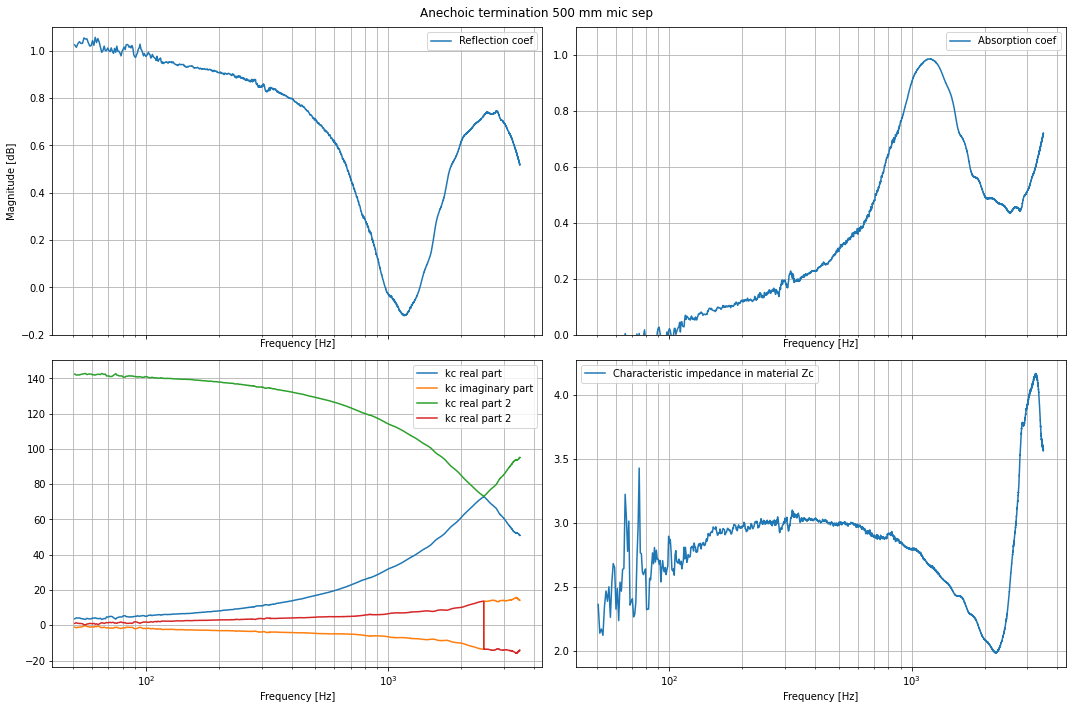

In [18]:
idx = (freq > 50) & (freq< 3500)

fig, ax = plt.subplots(2,2, figsize=(15, 10) ,sharex=True)
ax = ax.flatten()
ax[0].semilogx(freq[idx], R_coef_anec_05[idx], label='Reflection coef')
#ax[0].semilogx(freq[idx], R_coef_anec[idx], label='Reflection coef')
ax[1].semilogx(freq[idx], alpha_coef_anec_05[idx], label='Absorption coef')
#ax[1].semilogx(freq[idx], alpha_coef_anec[idx], label='Absorption coef')
ax[2].semilogx(freq[idx], kc_anec_05[idx].real, label='kc real part')
ax[2].semilogx(freq[idx], kc_anec_05[idx].imag, label='kc imaginary part')
ax[2].semilogx(freq[idx], real_kc_anec_05[idx], label='kc real part 2')
ax[2].semilogx(freq[idx], imag_kc_anec_05[idx], label='kc real part 2')

ax[3].semilogx(freq[idx], Zc_anec_05[idx], label='Characteristic impedance in material Zc')

ax[0].legend()
ax[0].set_ylabel('Magnitude [dB]')

ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

ax[0].set_ylim([-0.2, 1.1])
ax[1].set_ylim([0, 1.1])

ax[0].grid(which='both')
ax[1].grid(which='both')
ax[2].grid(which='both')
ax[3].grid(which='both')

ax[0].set_xlabel('Frequency [Hz]')
ax[1].set_xlabel('Frequency [Hz]')
ax[2].set_xlabel('Frequency [Hz]')
ax[3].set_xlabel('Frequency [Hz]')

plt.suptitle('Anechoic termination 500 mm mic sep')
plt.tight_layout()

plt.show()

### Measurement with short mic separation (45 mm), rigid termination

In [8]:
YM2coarse_anech45_1234 = io.loadmat('YM2_coarse_d1_s1_anec_1V_1234.mat')
YM2coarse_anech45_2134 = io.loadmat('YM2_coarse_d1_s1_anec_1V_2134.mat')    
YM2coarse_anech45_3214 = io.loadmat('YM2_coarse_d1_s1_anec_1V_3214.mat') 
YM2coarse_anech45_4231 = io.loadmat('YM2_coarse_d1_s1_anec_1V_4231.mat')

freq = YM2coarse_anech45_1234['FFT1_H1_2_1_X_Val'].flatten()

H12d = YM2coarse_anech45_1234['FFT1_H1_2_1_Y_ReIm'].flatten()
H13d = YM2coarse_anech45_1234['FFT1_H1_3_1_Y_ReIm'].flatten()
H14d = YM2coarse_anech45_1234['FFT1_H1_4_1_Y_ReIm'].flatten()

H12i = YM2coarse_anech45_2134['FFT1_H1_2_1_Y_ReIm'].flatten()
H13i = YM2coarse_anech45_3214['FFT1_H1_3_1_Y_ReIm'].flatten()
H14i = YM2coarse_anech45_4231['FFT1_H1_4_1_Y_ReIm'].flatten()

Hc12 = (H12d * H12i)**0.5
Hc13 = (H13d * H13i)**0.5 
Hc14 = (H14d * H14i)**0.5  
H11 = 1
H12 = H12d/Hc12
H13 = H13d/Hc13 
H14 = H14d/Hc14

l1 = 30e-3
s1 = 45e-3
l2 = 50e-3 + 30e-3
s2 = 45e-3
d = 43e-3

k = 2*np.pi*freq / c0

A = 1j*((H11*np.exp(-1j*k*l1) - H12*np.exp(-1j*k*(l1+s1))) / (2*np.sin(k*s1))) 
B = 1j*((H12*np.exp(1j*k*(l1+s1)) - H11*np.exp(1j*k*(l1))) / (2*np.sin(k*s1))) 
C = 1j*((H13*np.exp(1j*k*(l2+s2)) - H14*np.exp(1j*k*(l2))) / (2*np.sin(k*s2))) 
D = 1j*((H14*np.exp(-1j*k*l2) - H13*np.exp(-1j*k*(l2+s2))) / (2*np.sin(k*s2)))

p0 = A + B
pd = C*np.exp(-1j*k*d) + D*np.exp(1j*k*d)
u0 = (A - B) / (rho*c0) 
ud = (C*np.exp(-1j*k*d) - D*np.exp(1j*k*d)) / (rho*c0)

T11 = ((pd*ud + p0*u0) / (p0*ud + pd*u0))#.reshape(-1,1)
T12 = ((p0**2 - pd**2) / (p0*ud + pd*u0))#.reshape(-1,1)
T21 = ((u0**2 - ud**2) / (p0*ud + pd*u0))#.reshape(-1,1)
T22 =((pd*ud + p0*u0) / (p0*ud + pd*u0))#.reshape(-1,1)

#T_matrix = np.matrix([[T11 , T12], [T21 ,T22]])
T_matrix = np.empty((2,2), dtype=object)
T_matrix[0, 0] = T11
T_matrix[0, 1] = T12
T_matrix[1, 0] = T21

R_coef_anec_1 = (T_matrix[0, 0] - rho*c0*T_matrix[1, 0]) / (T_matrix[0, 0] + rho*c0*T_matrix[1, 0]) 
alpha_coef_anec_1 = 1 - np.abs(R_coef_anec_1**2)
kc_anec_1 = (1/d) * np.arccos(T_matrix[0, 0])
Zc_anec_1 = np.sqrt(T_matrix[0, 1] / T_matrix[1, 0]) /z0

C:\Users\joaqu\AppData\Local\Temp\ipykernel_901764\1542037080.py:32: RuntimeWarning: divide by zero encountered in true_divide
  A = 1j*((H11*np.exp(-1j*k*l1) - H12*np.exp(-1j*k*(l1+s1))) / (2*np.sin(k*s1)))
C:\Users\joaqu\AppData\Local\Temp\ipykernel_901764\1542037080.py:32: RuntimeWarning: invalid value encountered in true_divide
  A = 1j*((H11*np.exp(-1j*k*l1) - H12*np.exp(-1j*k*(l1+s1))) / (2*np.sin(k*s1)))
C:\Users\joaqu\AppData\Local\Temp\ipykernel_901764\1542037080.py:32: RuntimeWarning: invalid value encountered in multiply
  A = 1j*((H11*np.exp(-1j*k*l1) - H12*np.exp(-1j*k*(l1+s1))) / (2*np.sin(k*s1)))
C:\Users\joaqu\AppData\Local\Temp\ipykernel_901764\1542037080.py:33: RuntimeWarning: divide by zero encountered in true_divide
  B = 1j*((H12*np.exp(1j*k*(l1+s1)) - H11*np.exp(1j*k*(l1))) / (2*np.sin(k*s1)))
C:\Users\joaqu\AppData\Local\Temp\ipykernel_901764\1542037080.py:33: RuntimeWarning: invalid value encountered in true_divide
  B = 1j*((H12*np.exp(1j*k*(l1+s1)) - H11*np.ex

c:\Python39\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
c:\Python39\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
c:\Python39\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
c:\Python39\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


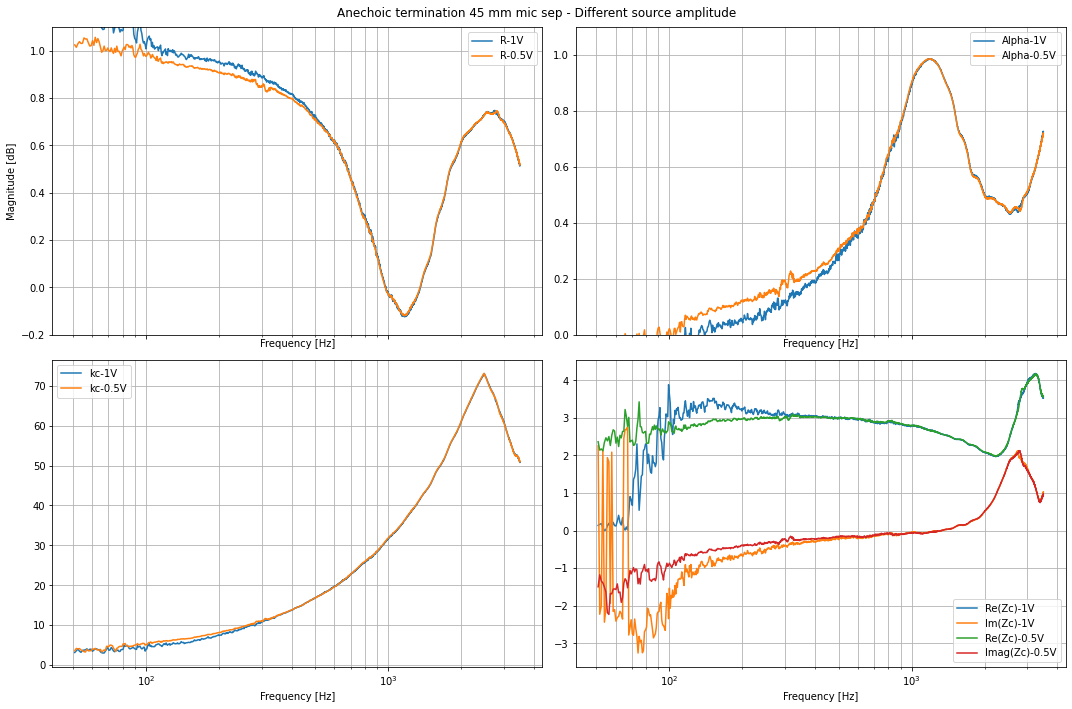

In [9]:
idx = (freq > 50) & (freq< 3500)

fig, ax = plt.subplots(2,2, figsize=(15, 10) ,sharex=True)
ax = ax.flatten()

ax[0].semilogx(freq[idx], R_coef_anec_1[idx], label='R-1V')
ax[0].semilogx(freq[idx], R_coef_anec_05[idx], label='R-0.5V')

ax[1].semilogx(freq[idx], alpha_coef_anec_1[idx], label='Alpha-1V')
ax[1].semilogx(freq[idx], alpha_coef_anec_05[idx], label='Alpha-0.5V')

ax[2].semilogx(freq[idx], kc_anec_1[idx], label='kc-1V')
ax[2].semilogx(freq[idx], kc_anec_05[idx], label='kc-0.5V')

ax[3].semilogx(freq[idx], Zc_anec_1[idx].real, label='Re(Zc)-1V')
ax[3].semilogx(freq[idx], Zc_anec_1[idx].imag, label='Im(Zc)-1V')
ax[3].semilogx(freq[idx], Zc_anec_05[idx].real, label='Re(Zc)-0.5V')
ax[3].semilogx(freq[idx], Zc_anec_05[idx].imag, label='Imag(Zc)-0.5V')

ax[0].legend()
ax[0].set_ylabel('Magnitude [dB]')

ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

ax[0].set_ylim([-0.2, 1.1])
ax[1].set_ylim([0, 1.1])

ax[0].grid(which='both')
ax[1].grid(which='both')
ax[2].grid(which='both')
ax[3].grid(which='both')

ax[0].set_xlabel('Frequency [Hz]')
ax[1].set_xlabel('Frequency [Hz]')
ax[2].set_xlabel('Frequency [Hz]')
ax[3].set_xlabel('Frequency [Hz]')

plt.suptitle('Anechoic termination 45 mm mic sep - Different source amplitude')
plt.tight_layout()

plt.show()

### Measurement with long mic separation (500 mm), rigid termination